In [5]:
PROJECT_ROOT = '/home/worker/DataScienceMLTest/'

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [7]:
def read_csv(filepath):
    """Auxiliary for reading csv files from project root.
    """
    csv = pd.read_csv(PROJECT_ROOT + filepath)
    csv['date'] = pd.to_datetime(csv['date'])
    csv = csv.sort_values('date').reset_index(drop=True)
    return csv

In [8]:
# Load training data

X_train = read_csv('training.csv')

# Cyclical dates encoding

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

In [10]:
class UnitCircleProjector(BaseEstimator, TransformerMixin):
    """Unit circle projector.

    Projects X into a unit circle by computing its sine and cosine 
    transformations.
    """

    def __init__(self, period):
        self.period = period
        
        self._sin_transformer = FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))
        self._cos_transformer = FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))


    def fit(self, X, y=None):
        return self

    def transform(self, X):
        sin = self._sin_transformer.fit_transform(X)
        cos = self._cos_transformer.fit_transform(X)
        return np.column_stack((sin, cos))
    
    
    
class CyclicalDatesEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, datetime_attrs):
        self.datetime_attrs = datetime_attrs
        
        
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X):
        projections = []
        for attr in self.datetime_attrs:
            x = getattr(X.dt, attr)
            x = UnitCircleProjector(period=x.max()).fit_transform(x)
            projections.append(x)
            
        return np.hstack(projections)


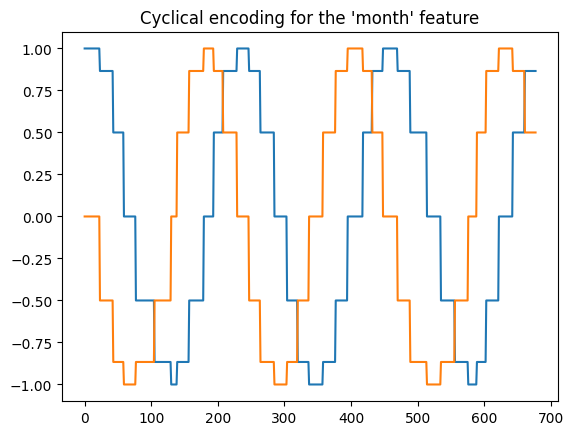

In [12]:
# Plot example

cyclical_month = CyclicalDatesEncoding(['month']).fit_transform(X_train.date)
plt.plot(cyclical_month)
plt.title("Cyclical encoding for the 'month' feature")
plt.savefig('cyclical_encoding.png', bbox_inches='tight', dpi=100)

# Image feature extraction

In [13]:
from skimage.io import imread
from skimage.feature import hog
import skimage

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from tqdm.auto import tqdm

/home/worker/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
def read_image(filepath):
    return imread(PROJECT_ROOT + filepath)

In [15]:
class ImageResizer(BaseEstimator, TransformerMixin):
    """Rezies images to given output shape.
    """
    def __init__(self, output_shape, anti_aliasing=False):
        self.output_shape = output_shape
        self.anti_aliasing = anti_aliasing
    
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X):
        return skimage.transform.resize(X, self.output_shape, anti_aliasing=self.anti_aliasing)


class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """Converts an array of RGB images to grayscale
    """ 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
        if X.ndim == 2:
            return X
        return skimage.color.rgb2gray(X)
    
    
class HogTransformer(BaseEstimator, TransformerMixin):
    """Calculates hog features.    
    """
 
    def __init__(self, **kwargs):
        self.kwargs = kwargs
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
        return hog(X, **self.kwargs)
    
    
class ArrayFlattener(BaseEstimator, TransformerMixin):
    """Wrapper for :pyfunc:`np.flatten`.
    """
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X):
        return X.flatten()
        

class FromPathImageTransformer(BaseEstimator, TransformerMixin):
    """Applies transformation to a collection of image paths.
    """
    def __init__(self, transformer, root_path='', stack_output=False):
        self.transformer = transformer
        self.root_path = root_path
        self.stack_output = stack_output
    
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        imgs = []
        for path in tqdm(X, desc="Image transforms", bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
            im = self.read_image(path)
            im = self.transform_image(im)
            imgs.append(im)
        
        if self.stack_output:
            return np.stack(imgs)
        return imgs
    
    def transform_image(self, img):
        return self.transformer.transform(img)
    
    def read_image(self, path):
        full_path = self.root_path + path
        return imread(full_path)
    
    
class AlphaChannelRemover(BaseEstimator, TransformerMixin):    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.has_alpha(X):
            return X[:, :, :3]
        return X
    
    
    def has_alpha(self, X):
        return X.shape[-1] == 4

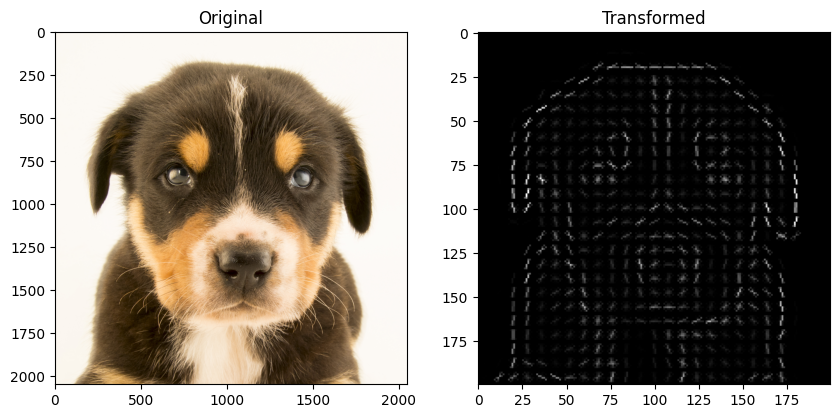

In [35]:
# One image transformation example.

img_pipeline = make_pipeline(
    *[
        RGB2GrayTransformer(),
        ImageResizer(output_shape=(200, 200), anti_aliasing=True),
        HogTransformer(visualize=True)
    ]
)

one_image = read_image(X_train['image'][3])
_, one_image_transformed = img_pipeline.fit_transform(one_image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(one_image, cmap='gray')
ax1.set_title('Original')

ax2.imshow(one_image_transformed, cmap='gray')
ax2.set_title('Transformed')

plt.savefig('image_transform.png', bbox_inches='tight', dpi=100)


In [36]:
img_pipeline

Pipeline(steps=[('rgb2graytransformer', RGB2GrayTransformer()),
                ('imageresizer',
                 ImageResizer(anti_aliasing=True, output_shape=(200, 200))),
                ('hogtransformer', HogTransformer())])

# Feature selection

For this purpose, we will try a tree-based feature selection.

In [38]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel

In [39]:
# Example using only numerical columns.

X_num = X_train.select_dtypes(exclude=['object', np.datetime64])
y = X_num.pop('target')

selector = SelectFromModel(ExtraTreesRegressor(n_estimators=10))
selector.fit(X_num, y)
selection = selector.transform(X_num)

print(f'Number of features before: {X_num.shape[1]}')
print(f'Number of features after: {selection.shape[1]}')

Number of features before: 15
Number of features after: 3


# Bringing all together in a single pipeline

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor

The final image transformer (:class:`FromPathImageTransformer`) takes filepaths as input and processes 
the images using whatever transformer is given through its ***transformer*** parameter. 
For this case, the ***transformer*** is itself a sklearn :class:`Pipeline` containing 3 image transformations:

- RGB2GrayTransformer
- ImageResizer.
- HogTransformer

In [41]:
# Create image transformer.

image_pipeline = make_pipeline(
    *[
        AlphaChannelRemover(),
        RGB2GrayTransformer(),
        ImageResizer(output_shape=(200, 200), anti_aliasing=True),
        HogTransformer()
    ]
)
image_transformer = FromPathImageTransformer(image_pipeline, root_path=PROJECT_ROOT, stack_output=True)

Dates will be encoded cyclically using trigonometric transformations (*sin* and *cos*).

In [42]:
# Create cyclical dates encoder

datetime_attrs = ['day', 'month', 'dayofweek']
dates_encoder = CyclicalDatesEncoding(datetime_attrs)

Images classes will be one hot encoded

In [43]:
ohe = OneHotEncoder()

All data transformations will be placed together in a sklearn :class:`Pipeline` called ``preprocessor``.

In [44]:
# Create preprocessor, a sklearn :class:`Pipeline` containing all data transformations.

ct = make_column_transformer(
    (image_transformer, 'image'), 
    (dates_encoder, 'date'), 
    (ohe, ['image class']),
    remainder='passthrough')

preprocessor = Pipeline(
    [
        ('column_transformer', ct),
        ('scaler', MinMaxScaler())
    ]
)

Like it was mentioned in the previous section, feature selection will be done using a tree-based model.

In [45]:
# Create feature selector.

selector = SelectFromModel(ExtraTreesRegressor(n_estimators=10))

Now we can bring everything together in a new :class:``Pipeline`` (another one? yes! 🤠) called ``estimator`` containing the following
* preprocessor: Transforms data prior to fit.
* selector: Selects relevant features.
* regressor: Fits data

In [46]:
# Example of a GradientBoosting pipeline estimator.

estimator = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('selector', selector),
        ('regressor', GradientBoostingRegressor())
    ]
)


In [47]:
estimator

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('column_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('frompathimagetransformer',
                                                                   FromPathImageTransformer(root_path='/home/worker/DataScienceMLTest/',
                                                                                            stack_output=True,
                                                                                            transformer=Pipeline(steps=[('alphachannelremover',
                                                                                                                         AlphaChannelRemover()),
                                                                                                                        ('rgb2graytransformer',
                                                                                                                         RGB2GrayTran...
                                                                                                                        ('hogtransformer',
                                                                                                                         HogTransformer())])),
                                                                   'image'),
                                                                  ('cyclicaldatesencoding',
                                                                   CyclicalDatesEncoding(datetime_attrs=['day',
                                                                                                         'month',
                                                                                                         'dayofweek']),
                                                                   'date'),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(),
                                                                   ['image '
                                                                    'class'])])),
                                 ('scaler', MinMaxScaler())])),
                ('selector',
                 SelectFromModel(estimator=ExtraTreesRegressor(n_estimators=10))),
                ('regressor', GradientBoostingRegressor())])

# Model selection

We will compare the learning curves of a feedforward neural network and a gradient boosting regressor to decide which one to use.

In [21]:
from sklearn.model_selection import learning_curve
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

In [22]:
def plot_learning_curve(train_sizes, train_scores, test_scores, score_name="", ax=None, negate_scores=False, title=""):
    """Auxiliary for plotting learning curve.
    """
    if ax is None:
        _, ax = plt.subplots()
        
    if negate_scores:
        train_scores, test_scores = -train_scores, -test_scores
        
    ax.plot(train_sizes, train_scores.mean(axis=1), marker='o')
    ax.plot(train_sizes, test_scores.mean(axis=1), marker='o')
    
    ax.set_xlabel("Number of samples in the training set")
    ax.set_ylabel(f"{score_name}")
    ax.set_title(f"{title}")
        
    
    

In [24]:
# Define y_train and drop image class feature.

if 'target' in X_train:
    y_train = X_train.pop('target')

In [25]:
# Preprocessor training data.

X_train_transformed = preprocessor.fit_transform(X_train)

Image transforms:  48%|████▊     | 326/678 [00:32<00:50,  6.91it/s]                                                                                                                                             /home/worker/.local/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:646: UserWarning: Metadata Warning, tag 33723 had too many entries: 172, expected 1
  warnings.warn(
Image transforms: 100%|██████████| 678/678 [01:08<00:00,  9.85it/s]                                                                                                                                             


In [26]:
# Select relevant features

X_selected = selector.fit_transform(X_train_transformed, y_train)

In [27]:
# Compute gradient boosting learning curve.

gbr = GradientBoostingRegressor()
gbr_train_sizes, gbr_train_scores, gbr_valid_scores  = learning_curve(
    gbr, X=X_selected, y=y_train, scoring='neg_root_mean_squared_error')

In [28]:
# Compute feedforward learning curve.

nn = MLPRegressor()
nn_train_sizes, nn_train_scores, nn_valid_scores  = learning_curve(
    nn, X=X_selected, y=y_train, scoring='neg_root_mean_squared_error')

/home/worker/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/worker/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/worker/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/worker/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/worker/.local/lib/python3.9/site-packages/skle

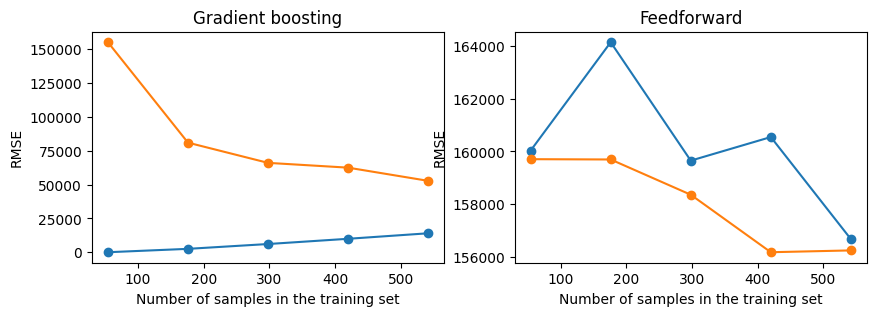

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

plot_learning_curve(
    gbr_train_sizes, gbr_train_scores, gbr_valid_scores, 
    score_name='RMSE', negate_scores=True, title='Gradient boosting',
    ax=ax1
)

plot_learning_curve(
    nn_train_sizes, nn_train_scores, nn_valid_scores, 
    score_name='RMSE', negate_scores=True, title='Feedforward',
    ax=ax2
)